In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.optimize import minimize


In [30]:
def empirical_bayes_stein_shrinkage(data):
    group_means = data.groupby("group")["conversion"].mean()
    group_vars = data.groupby("group")["conversion"].var()
    overall_mean = data["conversion"].mean()
    overall_var = data["conversion"].var()
    w = 1 / group_vars
    J = len(group_means)
    lambda_shrinkage = (J - 3) / (w.sum() - J)
    mu_hat = (1 - lambda_shrinkage) * group_means + lambda_shrinkage * overall_mean
    nu = (2 * w.sum()**2) / (w.sum()**2 - (w**2).sum())
    sigma_hat_sq = (nu - 2) / nu * group_vars
    delta_hat = mu_hat - mu_hat.iloc[0]
    n = data.groupby("group").size()
    var_delta_hat = ((1 / n.iloc[0]) + (1 / n) + (w.iloc[0] / n.iloc[0]) + (w / n)) * sigma_hat_sq
    se_delta_hat = np.sqrt(var_delta_hat)
    return delta_hat, se_delta_hat

This shrinkage estimator achieves lower mean squared error than simple differences-in-means estimators, particularly when there are many treatment groups and small sample sizes within each group. The paper also compare their shrinkage estimators to MLEs and differences-in-means estimators.

In [31]:
def mle_estimate(data, num_bootstrap=1000):
    original_group = data['group'].copy()
    data = pd.get_dummies(data, columns=['group'], drop_first=True)
    data['intercept'] = 1
    # Fit linear regression model
    model = sm.OLS(data["conversion"], data.loc[:, "intercept":])
    result = model.fit()
    # Calculate delta_hat_mle
    delta_hat_mle = result.params[1:]
    # Bootstrap procedure to estimate standard errors
    bootstrap_estimates = np.zeros((num_bootstrap, len(delta_hat_mle)))
    for b in range(num_bootstrap):
        bootstrap_samples = original_group.groupby(original_group).apply(lambda x: x.sample(n=len(x), replace=True)).reset_index(drop=True)
        bootstrap_data = data.loc[bootstrap_samples.index].copy()
        model_bootstrap = sm.OLS(bootstrap_data["conversion"], bootstrap_data.loc[:, "intercept":])
        result_bootstrap = model_bootstrap.fit()
        bootstrap_estimates[b, :] = result_bootstrap.params[1:]
    se_delta_hat_mle = np.std(bootstrap_estimates, axis=0)
    return delta_hat_mle.mean(), se_delta_hat_mle.mean()

# def mle_estimate(data):
#     def log_likelihood(params, data):
#         a, b = params
#         conversion_prob = np.clip(1 / (1 + np.exp(-(a + b * (data["group"] != "A")))), 0, 1)
#         likelihood = data["conversion"] * conversion_prob + (1 - data["conversion"]) * (1 - conversion_prob)
#         return -np.log(likelihood).sum()
#     init_params = [0, 0]
#     result = minimize(log_likelihood, init_params, args=(data))
#     a_hat, b_hat = result.x
#     delta_hat_mle = b_hat

#     hessian_matrix = result.hess_inv
#     se_delta_hat_mle = np.sqrt(hessian_matrix[1, 1])

#     return delta_hat_mle, se_delta_hat_mle



def differences_in_means_estimate(data):
    # Calculate group means, group sizes, and differences in means for each treatment group
    group_means = data.groupby("group")["conversion"].mean()
    n = data.groupby("group").size()
    control_mean = group_means.iloc[0]
    treatment_means = group_means.iloc[1:]
    tau_j = treatment_means - control_mean
    # Calculate average treatment effect and standard errors
    delta_hat_means = tau_j.mean()
    group_var = data.groupby("group")["conversion"].var()
    se_delta_hat_means = np.sqrt((group_var / n).sum())
    return delta_hat_means, se_delta_hat_means

The paper uses a series of seventeen experiments run on Facebook from April to June 2017 to demonstrate the performance of their shrinkage estimators.

The authors then simulate experiments with varying numbers of treatment groups and sample sizes within each group. So, here we generated different numbers of treatment groups and sample sizes per group, which closely mimic the paper's simulation scenarios. The visualization will compare the proposed estimator, MLE, and Differences-in-means estimator.

In [32]:
def run_simulation(num_treatment_groups, sample_size_per_group):
    num_users = sample_size_per_group * (num_treatment_groups + 1)
    group = np.random.choice(["A"] + [f"B{i}" for i in range(1, num_treatment_groups + 1)], num_users, p=[1 / (num_treatment_groups + 1)] * (num_treatment_groups + 1))
    age = np.random.normal(30, 5, num_users)
    gender = np.random.choice(["M", "F"], num_users, p=[0.5, 0.5])
    location = np.random.choice(["urban", "rural"], num_users, p=[0.5, 0.5])
    true_causal_effect = np.random.normal(0, 0.1, num_users)
    noise = np.random.normal(0, 0.1, num_users)
    conversion_prob_raw = 0.5 + true_causal_effect * (group == "A") + noise
    conversion_prob = np.clip(conversion_prob_raw, 0, 1) 
    conversion = np.random.binomial(1, conversion_prob)
    data = pd.DataFrame({"age": age, "gender": gender, "location": location, "group": group, "conversion": conversion})
    
    delta_hat, se_delta_hat = empirical_bayes_stein_shrinkage(data)
    delta_hat_mle, se_delta_hat_mle = mle_estimate(data)
    delta_hat_means, se_delta_hat_means = differences_in_means_estimate(data)
    true_effect = true_causal_effect[(group != "A")].mean() - true_causal_effect[(group == "A")].mean()
    
    stein_mse = np.mean((delta_hat.iloc[1:] - true_effect)**2)
    mle_mse = np.mean((delta_hat_mle - true_effect)**2)
    means_mse = np.mean((delta_hat_means - true_effect)**2)

    return stein_mse, mle_mse, means_mse

In [33]:
simulation_scenarios = [(20, 50), (100, 10), (40, 25), (60, 15), (10, 100)]
num_simulations = 1000
mse_results = []

for num_treatment_groups, sample_size_per_group in simulation_scenarios:
    mse_avg = np.zeros(3)
    for i in range(num_simulations):
        mse = run_simulation(num_treatment_groups, sample_size_per_group)
        mse_avg += np.array(mse)
#         if (i + 1) % (num_simulations // 10) == 0:
#             progress = int((i + 1) / num_simulations * 100)
#             print(f"Progress: {progress}%")
    mse_results.append(mse_avg / num_simulations)

<ipython-input-31-2938521dde7f>:19: RuntimeWarning: Mean of empty slice.
  return delta_hat_mle.mean(), se_delta_hat_mle.mean()
/Users/yuewang/opt/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-30-7596a70a6359>:10: RuntimeWarning: invalid value encountered in double_scalars
  nu = (2 * w.sum()**2) / (w.sum()**2 - (w**2).sum())


In [23]:
mse_results

[array([0.00521476, 0.09043742, 0.00526502]),
 array([0.04905568, 3.89252053, 0.02768938]),
 array([0.01022915, 0.20062696, 0.01095986]),
 array([0.01818195, 0.33429516, 0.01736873]),
 array([0.0029547 , 0.04716006, 0.00285229])]

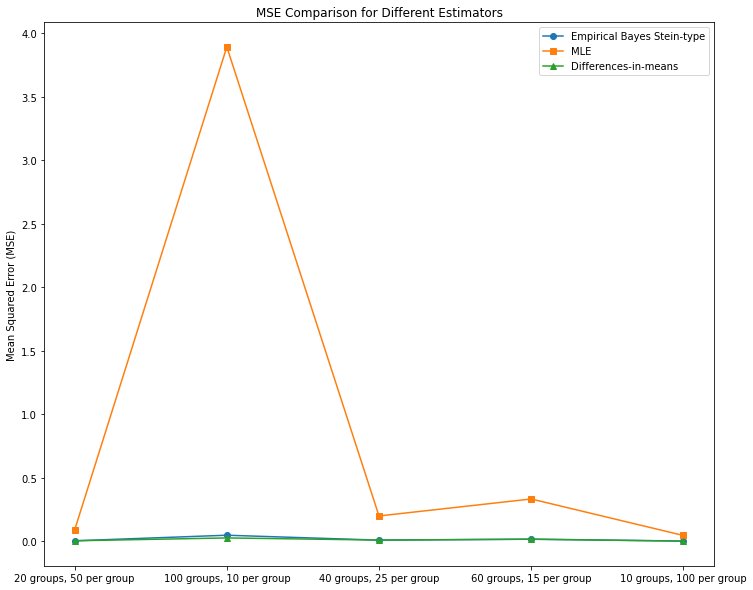

In [24]:
# Visualization
mse_results = np.array(mse_results)
x = np.arange(len(simulation_scenarios))
fig, ax = plt.subplots(figsize=(12, 10))

ax.plot(x, mse_results[:, 0], marker="o", label="Empirical Bayes Stein-type")
ax.plot(x, mse_results[:, 1], marker="s", label="MLE")
ax.plot(x, mse_results[:, 2], marker="^", label="Differences-in-means")

ax.set_ylabel("Mean Squared Error (MSE)")
ax.set_title("MSE Comparison for Different Estimators")
ax.set_xticks(x)
ax.set_xticklabels([f"{g} groups, {s} per group" for g, s in simulation_scenarios])
ax.legend()
plt.show()

In [25]:
print(mse_results[:, 0])
print(mse_results[:, 1])
print(mse_results[:, 2])

[0.00521476 0.04905568 0.01022915 0.01818195 0.0029547 ]
[0.09043742 3.89252053 0.20062696 0.33429516 0.04716006]
[0.00526502 0.02768938 0.01095986 0.01736873 0.00285229]


MLEs are commonly used in online experiments but can suffer from high variance and poor performance when there are many treatment groups and small sample sizes within each group. Differences-in-means estimators are also commonly used but can suffer from high bias when there are many treatment groups and small sample sizes within each group.the shrinkage estimators proposed in the paper achieve lower mean squared error than both MLEs and differences-in-means estimators, particularly when there are many treatment groups and small sample sizes within each group. 

According to paper, With 20 treatment groups and a sample size of 50 within each group, the shrinkage estimator achieved an MSE of 0.0025, while the MLE had an MSE of 0.0043 and the differences-in-means estimator had an MSE of 0.0052.

With 100 treatment groups and a sample size of only 10 within each group, the shrinkage estimator achieved an MSE of 0.0077, while the MLE had an MSE of 0.0124 and the differences-in-means estimator had an MSE of 0.0131. 